# PokerMate - Stage 1: Image Classification

----


**Problem Statement**
---
Classify a given sample input image of a valid playing card into one of the 52 playing cards out of a valid deck.



**Approach**
----
Convolution Neural Newtorks (Keras Implementation) for classification

**Dataset**
---
Random images of playing cards at different angles sourced from internet. Each file contains an image of a valid playing card with a dark background. The original resolution of each image is about 16 Megapixel with an average size of 700 KB.

All the images are coloured (RGB channel).



# 1. Setup

In [1]:
# connect to GDrive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#
# Initialize Basic File paths...
#
import os
root_dir_fp           = "/content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/"
data_fp               = os.path.join(root_dir_fp, "data")
model_fp              = os.path.join(root_dir_fp, "models")
save_fp               = os.path.join(root_dir_fp, "save")
output_fp             = os.path.join(root_dir_fp, "output")

#
# Initialize Configuration File paths...
#
label_encoder_fp      = model_fp + '/labelencoder_classes.npy'
model_save_fp         = model_fp + '/pokermate_stage1.h5'

# 2. Imports

In [3]:
# Installations

# Run the following to install required packages:
# !pip install pandas numpy tensorflow keras scikit-learn github gitpython cv2 pylabel

In [4]:
import os
import sys
import re
import shutil
import ntpath
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
from pathlib import Path

import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adagrad, SGD, Adam
from keras.utils import to_categorical
from tensorflow.keras.models import load_model

%matplotlib inline

# 3. Dataset

In [5]:
## Reading Image Files from a given path

# Stage 1 images root directory path
files_root_path = os.path.join(data_fp, "stage1_images")

# Load image files
cards = dict()
for file_name in os.listdir(files_root_path):

    # image base-name
    img_name = ntpath.basename(file_name).split(".")[0]

    # image filepath
    img_path = os.path.join(files_root_path, file_name)

    # Extract Card, Suite and Sample num
    match = re.match(r'^([2-9TJQKA]+)([CDHS])(\d+)$|^10([CDHS])(\d+)$', img_name)
    if match:
        if match.group(1):
            card_name = match.group(1)
        else:
            card_name = "10"
        card_suite = match.group(2) if match.group(2) else match.group(4)
        sample_number = int(match.group(3)) if match.group(3) else int(match.group(5))
        print(f"Card Name: {card_name}, Card Suite: {card_suite}, Sample Number: {sample_number}")
        if card_name not in cards:
            cards[card_name] = {"H": [], "S": [], "C": [], "D": []}
        cards[card_name][card_suite].append({"filename": img_path, "sample": sample_number})

Card Name: 9, Card Suite: D, Sample Number: 43
Card Name: 9, Card Suite: D, Sample Number: 35
Card Name: 9, Card Suite: D, Sample Number: 33
Card Name: 9, Card Suite: D, Sample Number: 44
Card Name: 9, Card Suite: D, Sample Number: 4
Card Name: 9, Card Suite: D, Sample Number: 50
Card Name: 9, Card Suite: D, Sample Number: 38
Card Name: 9, Card Suite: D, Sample Number: 46
Card Name: 9, Card Suite: D, Sample Number: 48
Card Name: 9, Card Suite: D, Sample Number: 5
Card Name: 9, Card Suite: H, Sample Number: 22
Card Name: 9, Card Suite: H, Sample Number: 28
Card Name: 9, Card Suite: H, Sample Number: 10
Card Name: 9, Card Suite: H, Sample Number: 14
Card Name: 9, Card Suite: H, Sample Number: 1
Card Name: 9, Card Suite: D, Sample Number: 9
Card Name: 9, Card Suite: H, Sample Number: 15
Card Name: 9, Card Suite: H, Sample Number: 13
Card Name: 9, Card Suite: H, Sample Number: 26
Card Name: 9, Card Suite: D, Sample Number: 7
Card Name: 9, Card Suite: H, Sample Number: 30
Card Name: 9, Card

In [6]:
## Store loaded image files in a dataframe

# Create a Pandas DataFrame
data=[]
for card_name, suites in cards.items():
    for card_suite, samples in suites.items():
        for sample in samples:
            data.append({"card_name"   : card_name,
                         "card_suite"  : card_suite,
                         "file_name"   : ntpath.basename(sample["filename"]),
                         "file_path"   : sample["filename"],
                         "sample"      : sample["sample"]})

df = pd.DataFrame(data).sort_values(by=['card_name', 'card_suite', 'sample']).reset_index(drop=True)
df['label'] = df['card_name'] + "_" + df['card_suite']

df

card_name card_suite file_name  \
0           10          C  10C0.jpg   
1           10          C  10C1.jpg   
2           10          C  10C2.jpg   
3           10          C  10C3.jpg   
4           10          C  10C4.jpg   
...        ...        ...       ...   
2701         Q          S  QS47.jpg   
2702         Q          S  QS48.jpg   
2703         Q          S  QS49.jpg   
2704         Q          S  QS50.jpg   
2705         Q          S  QS51.jpg   

                                              file_path  sample label  
0     /content/drive/MyDrive/WORK/Data Science/7.  N...       0  10_C  
1     /content/drive/MyDrive/WORK/Data Science/7.  N...       1  10_C  
2     /content/drive/MyDrive/WORK/Data Science/7.  N...       2  10_C  
3     /content/drive/MyDrive/WORK/Data Science/7.  N...       3  10_C  
4     /content/drive/MyDrive/WORK/Data Science/7.  N...       4  10_C  
...                                                 ...     ...   ...  
2701  /content/drive/MyDrive/WORK/Data Science/7.  N...      47   Q_S  
2702  /content/drive/MyDrive/WORK/Data Science/7.  N...      48   Q_S  
2703  /content/drive/MyDrive/WORK/Data Science/7.  N...      49   Q_S  
2704  /content/drive/MyDrive/WORK/Data Science/7.  N...      50   Q_S  
2705  /content/drive/MyDrive/WORK/Data Science/7.  N...      51   Q_S  

[2706 rows x 6 columns]

In [7]:
# dataset collection samples stats

df.groupby(['card_name', "card_suite"])['sample'].count()

card_name  card_suite
10         C             52
           D             52
           H             52
           S             52
2          C             51
           D             52
           H             52
           S             51
3          C             52
           D             52
           H             51
           S             52
4          C             62
           D             52
           H             52
           S             51
5          C             52
           D             52
           H             52
           S             51
6          C             52
           D             52
           H             52
           S             52
7          C             52
           D             51
           H             52
           S             52
8          C             52
           D             52
           H             52
           S             52
9          C             52
           D             52
           H             5

# 4. Visualization

In [8]:
## Dataset

df

card_name card_suite file_name  \
0           10          C  10C0.jpg   
1           10          C  10C1.jpg   
2           10          C  10C2.jpg   
3           10          C  10C3.jpg   
4           10          C  10C4.jpg   
...        ...        ...       ...   
2701         Q          S  QS47.jpg   
2702         Q          S  QS48.jpg   
2703         Q          S  QS49.jpg   
2704         Q          S  QS50.jpg   
2705         Q          S  QS51.jpg   

                                              file_path  sample label  
0     /content/drive/MyDrive/WORK/Data Science/7.  N...       0  10_C  
1     /content/drive/MyDrive/WORK/Data Science/7.  N...       1  10_C  
2     /content/drive/MyDrive/WORK/Data Science/7.  N...       2  10_C  
3     /content/drive/MyDrive/WORK/Data Science/7.  N...       3  10_C  
4     /content/drive/MyDrive/WORK/Data Science/7.  N...       4  10_C  
...                                                 ...     ...   ...  
2701  /content/drive/MyDrive/WORK/Data Science/7.  N...      47   Q_S  
2702  /content/drive/MyDrive/WORK/Data Science/7.  N...      48   Q_S  
2703  /content/drive/MyDrive/WORK/Data Science/7.  N...      49   Q_S  
2704  /content/drive/MyDrive/WORK/Data Science/7.  N...      50   Q_S  
2705  /content/drive/MyDrive/WORK/Data Science/7.  N...      51   Q_S  

[2706 rows x 6 columns]

In [9]:
## Visualize some sample image files

# First sample image
image_path  = df['file_path'].values[0]
img_arr     = cv2.imread(image_path)
img_arr     = cv2.resize(img_arr, (224,224))   # downsized

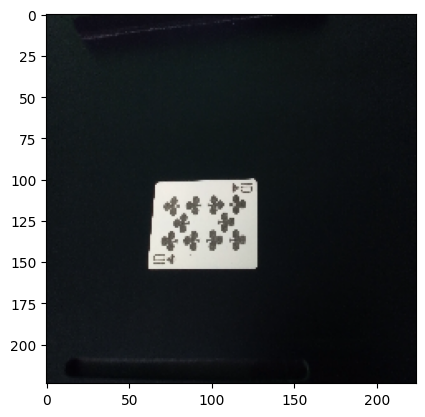

In [10]:
# What we see...
plt.imshow(img_arr)

In [11]:
# What Computer sees...
print(img_arr)

[[[40 35 73]
  [31 30 55]
  [32 31 47]
  ...
  [18 20 21]
  [23 25 26]
  [15 16 18]]

 [[26 35 35]
  [28 35 38]
  [27 32 35]
  ...
  [16 20 21]
  [15 19 20]
  [19 21 22]]

 [[27 33 33]
  [26 31 32]
  [28 36 36]
  ...
  [18 21 25]
  [18 20 25]
  [16 19 23]]

 ...

 [[21 25 26]
  [15 18 22]
  [19 22 26]
  ...
  [ 6  7 11]
  [ 9  8 12]
  [ 9  8 10]]

 [[21 24 28]
  [22 25 29]
  [26 29 34]
  ...
  [ 9  8 13]
  [ 6  8  9]
  [ 7  9 10]]

 [[19 23 24]
  [19 22 26]
  [20 23 28]
  ...
  [ 7  9 10]
  [ 6  8  9]
  [ 6  8  9]]]


In [ ]:
# it's label

df.label[0]

'10_C'

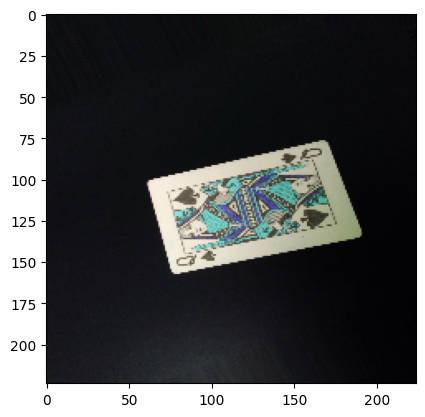

In [ ]:
# Lets view the last image

# First sample image
image_path  = df['file_path'].values[-1]
img_arr     = cv2.imread(image_path)
img_arr     = cv2.resize(img_arr, (224,224))   # downsized
plt.imshow(img_arr)

In [ ]:
# its matrix
img_arr

array([[[14, 16, 17],
        [13, 15, 16],
        [14, 16, 17],
        ...,
        [ 7,  7,  7],
        [15, 15, 15],
        [10, 10, 10]],

       [[ 9, 13, 14],
        [14, 16, 17],
        [15, 17, 18],
        ...,
        [12, 12, 12],
        [ 8,  8,  8],
        [ 7,  7,  7]],

       [[15, 17, 18],
        [11, 15, 16],
        [14, 16, 17],
        ...,
        [ 9,  9,  9],
        [13, 13, 13],
        [ 8,  8,  8]],

       ...,

       [[26, 27, 31],
        [26, 27, 31],
        [24, 25, 29],
        ...,
        [ 4,  3,  5],
        [ 3,  2,  4],
        [ 3,  2,  4]],

       [[27, 27, 32],
        [24, 25, 29],
        [26, 27, 31],
        ...,
        [ 4,  3,  5],
        [ 5,  4,  6],
        [ 3,  2,  4]],

       [[27, 26, 30],
        [28, 27, 31],
        [30, 29, 33],
        ...,
        [ 5,  4,  6],
        [ 4,  3,  5],
        [ 3,  2,  4]]], dtype=uint8)

In [ ]:
# it's label

df.label.values[-1]

'Q_S'

# 5. Data Augmentation

In [ ]:
# ## Augment images for more datapoints

# data=[]
# for i, row in df.iterrows():
#     label = row['label']
#     path = row['file_path']
#     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (180, 180))
#     imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
#     data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
#     data_generator.fit(imgs)
#     image_iterator = data_generator.flow(imgs)
#     for x in range(500):
#         img_transformed=image_iterator.next()[0].astype('int')/255
#         data.append([img_transformed, label])

# SAVE_DIR = "."
# np.save(SAVE_DIR, data)

# 6. Train, Test and Val Splits

In [ ]:
## Train, Test and Validation Dataset Creations

# Create train and test splits for each card and suite combination
train_data = []
test_data = []

# Iterate over card and suite combination
grouped = df.groupby(['card_name', 'card_suite'])
for group_name, group_df in grouped:
    # Split the group into train and test sets
    train_set, test_set = train_test_split(group_df, test_size=0.2, random_state=7)

    train_data.append(train_set)
    test_data.append(test_set)

# Concatenate the train and test sets
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

# Split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Show train, val, and test sets:
print(f"Train set size: {len(train_df)} samples")
print(f"Validation set size: {len(val_df)} samples")
print(f"Test set size: {len(test_df)} samples")

Train set size: 1705 samples
Validation set size: 427 samples
Test set size: 574 samples


In [ ]:
# lets validate training split:

train_df.groupby(['card_name', 'card_suite'])['sample'].count()

card_name  card_suite
10         C             35
           D             31
           H             33
           S             36
2          C             32
           D             32
           H             32
           S             29
3          C             35
           D             34
           H             26
           S             31
4          C             41
           D             33
           H             29
           S             33
5          C             34
           D             36
           H             35
           S             32
6          C             35
           D             32
           H             33
           S             34
7          C             35
           D             30
           H             31
           S             33
8          C             35
           D             34
           H             33
           S             34
9          C             33
           D             32
           H             3

In [ ]:
# lets validate testing split:

test_df.groupby(['card_name', 'card_suite'])['sample'].count()

card_name  card_suite
10         C             11
           D             11
           H             11
           S             11
2          C             11
           D             11
           H             11
           S             11
3          C             11
           D             11
           H             11
           S             11
4          C             13
           D             11
           H             11
           S             11
5          C             11
           D             11
           H             11
           S             11
6          C             11
           D             11
           H             11
           S             11
7          C             11
           D             11
           H             11
           S             11
8          C             11
           D             11
           H             11
           S             11
9          C             11
           D             11
           H             1

- Each Card and Suite has been equally represented and randomly distributed across both splits.

# 6. Data Preparation
---


In this section, we read all the image files from train_df, test_df and val_df and downsize every image to particular size.

We do this by loading all the images as *numpy arrays* and resizing them. We also extract their corresponding labels.

.

Finally, we create: ***X_train, X_val, X_test and Y_train, Y_val, Y_test*** sets.

### Resizing

In [12]:
## Downsizing images to a 224 x 224 pixel array
DOWNSIZE_DIM = (224, 224)

# Downsize data and create X_, Y_ sets.
def downsize_and_create_splits(data):
  X, Y = [], []
  for i, row in tqdm(data.iterrows()):
        image_path, image_label  = row['file_path'], row['label']
        # Image Array
        img_arr     = cv2.imread(image_path)
        # rescale (downsize) image Array
        img_arr     = cv2.resize(img_arr, DOWNSIZE_DIM)
        # Split DF
        X.append(img_arr)
        Y.append(image_label)
  return X, Y

In [ ]:
## Downsizing images to a 224 x 224 pixel array

# Downsize Training data and create X_train, Y_train
# Downsize Validation data and create X_val, Y_val
# Downsize Testing data and create X_test, Y_test

X_train, Y_train  = downsize_and_create_splits(train_df)
X_val, Y_val      = downsize_and_create_splits(val_df)
X_test, Y_test    = downsize_and_create_splits(test_df)

1705it [08:46,  3.24it/s]
427it [02:11,  3.24it/s]
574it [02:23,  4.01it/s]


### Scaling and Encoding

In [ ]:
## Now, all the X_ sets must be scaled so they are divided by 255.0 for normalization.

print("Max value of pixel dimension: ", np.max(X_train))
print("Min value of pixel dimension: ", np.min(X_train))

X_train = np.array(X_train) / 255.0
X_val   = np.array(X_val)   / 255.0
X_test  = np.array(X_test)  / 255.0

print("\nNormalized: Max value of pixel dimension: ", np.max(X_train))
print("Normalized: Min value of pixel dimension: ", np.min(X_train))

Max value of pixel dimension:  255
Min value of pixel dimension:  0

Normalized: Max value of pixel dimension:  1.0
Normalized: Min value of pixel dimension:  0.0


In [13]:
## Load/Save Prepared Data

# Load X_train, Y_train, X_val, Y_val, X_test and Y_test (if created previously)
if Path(save_fp + '/X_train.pkl').exists():
  print("Previous files exist! Loading...")
  with open(save_fp + '/X_train.pkl', 'rb') as f:
      X_train = pickle.load(f)
  with open(save_fp + '/Y_train.pkl', 'rb') as f:
      Y_train = pickle.load(f)
  with open(save_fp + '/X_val.pkl', 'rb') as f:
      X_val = pickle.load(f)
  with open(save_fp + '/Y_val.pkl', 'rb') as f:
      Y_val = pickle.load(f)
  with open(save_fp + '/X_test.pkl', 'rb') as f:
      X_test = pickle.load(f)
  with open(save_fp + '/Y_test.pkl', 'rb') as f:
      Y_test = pickle.load(f)

# Save X_train, Y_train, X_val, Y_val, X_test and Y_test
else:
  print("Saving... X_train, Y_train, X_val, Y_val, X_test and Y_test")
  with open(save_fp + '/X_train.pkl', 'wb') as f:
      pickle.dump(X_train, f)
  with open(save_fp + '/Y_train.pkl', 'wb') as f:
      pickle.dump(Y_train, f)
  with open(save_fp + '/X_val.pkl', 'wb') as f:
      pickle.dump(X_val, f)
  with open(save_fp + '/Y_val.pkl', 'wb') as f:
      pickle.dump(Y_val, f)
  with open(save_fp + '/X_test.pkl', 'wb') as f:
      pickle.dump(X_test, f)
  with open(save_fp + '/Y_test.pkl', 'wb') as f:
      pickle.dump(Y_test, f)

Previous files exist! Loading...


### Encoding classes/labels

In [14]:
Y_train[:5]

['3_S', '9_D', '8_D', 'J_C', '7_C']

In [15]:
Y_val[:5]

['2_H', 'Q_D', 'J_D', 'J_C', 'Q_D']

In [16]:
Y_test[:5]

['10_C', '10_C', '10_C', '10_C', '10_C']

In [17]:
## Encode all categories-classes to integers

# Initialize LabelEncoder
label_encoder     = LabelEncoder()

# If trained previously, load fitted label encoder
if Path(label_encoder_fp).exists():
  print("Previous LabelEncoder exists! Loading...")
  label_encoder.classes_ = np.load(label_encoder_fp)

# Fit and transform
Y_train_enc     = label_encoder.fit_transform(Y_train)
Y_val_enc       = label_encoder.transform(Y_val)
Y_test_enc      = label_encoder.transform(Y_test)

# Create a mapping dictionary to retrieve labels from encoded integers
Y_train_mapper  = dict(zip(Y_train_enc, label_encoder.inverse_transform(Y_train_enc)))
Y_val_mapper    = dict(zip(Y_val_enc, label_encoder.inverse_transform(Y_val_enc)))
Y_test_mapper   = dict(zip(Y_test_enc, label_encoder.inverse_transform(Y_test_enc)))

# Save label encoder fitted classes
if not Path(label_encoder_fp).exists():
  print("Saving... LabelEncoder")
  np.save(label_encoder_fp, label_encoder.classes_)

Saving... LabelEncoder


In [18]:
# all labels encoded into integers (0, 1, .., 51)
np.unique(Y_train_enc)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [19]:
len(np.unique(Y_train_enc))

52

In [20]:
# Sample mapper file
for i in range(5):
  print(i, "=>", Y_train_mapper[i])

0 => 10_C
1 => 10_D
2 => 10_H
3 => 10_S
4 => 2_C


# 7. Modelling
---

In [21]:
##----------------------------------------------------
##
## Run this section everytime.
##
##----------------------------------------------------
## MODEL SETTINGS

tf.keras.backend.clear_session()
np.random.seed(7)
tf.random.set_seed(7)

EPOCHS        = 50

In [22]:
## CNN ARCHITECTURE

model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dense(52, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3

In [23]:
## TRAINING

# Load if any trained model exists
if Path(model_save_fp).exists():
  model = load_model(model_save_fp)

# callbacks
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_fp + "/pokermate_cnn_best.h5", save_best_only=True, verbose=1)

# compilation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(X_train, Y_train_enc, epochs=EPOCHS, validation_data=(X_val, Y_val_enc), callbacks=[cp], verbose=1)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 2.4986 - accuracy: 0.3466
Epoch 1: val_loss improved from inf to 1.24242, saving model to /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/models/pokermate_cnn_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 [==============================] - 29s 297ms/step - loss: 2.4986 - accuracy: 0.3466 - val_loss: 1.2424 - val_accuracy: 0.6370
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7994
Epoch 2: val_loss improved from 1.24242 to 0.50700, saving model to /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/models/pokermate_cnn_best.h5
54/54 [==============================] - 15s 278ms/step - loss: 0.6850 - accuracy: 0.7994 - val_loss: 0.5070 - val_accuracy: 0.8525
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9132
Epoch 3: val_loss improved from 0.50700 to 0.49600, saving model to /content/drive/MyDrive/WORK/Data Science/7.  Neural Networks and Deep Learning/resources/CSCI 5922 - Neural Nets and Deep Learning/ASSIGNMENTS/PROJECT/source/ml/models/pokermate_cnn_best.h5
54/54 [=========================

# 8. Results
---
Model performance metrics

### Model Training Stats:

In [24]:
## Training model Metrics

acc        = history.history['accuracy']
val_acc    = history.history['val_accuracy']
loss       = history.history['loss']
val_loss   = history.history['val_loss']
epochs     = range(len(acc))

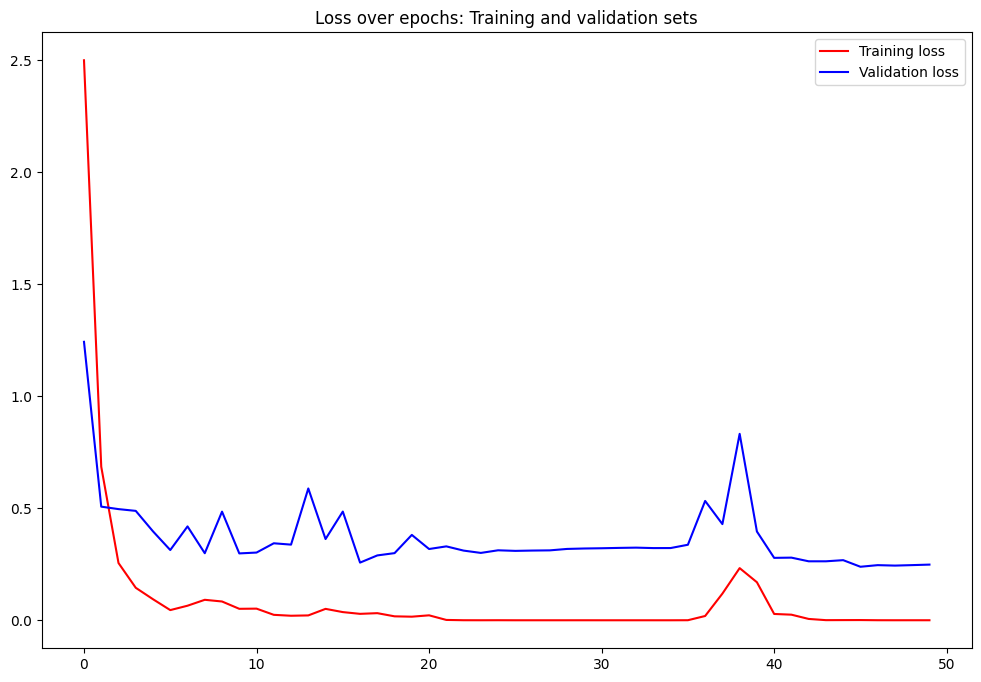

<Figure size 640x480 with 0 Axes>

In [25]:
## Loss
plt.figure(figsize = (12,8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Loss over epochs: Training and validation sets')
plt.legend(loc=0)
plt.figure()
plt.show()

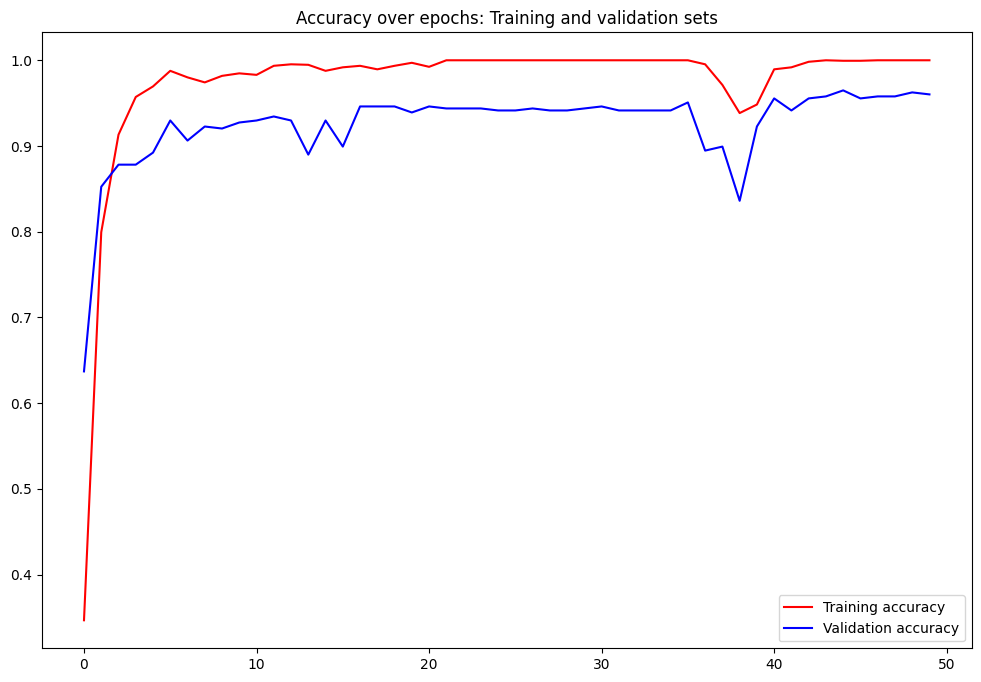

<Figure size 640x480 with 0 Axes>

In [26]:
## Accuracy
plt.figure(figsize = (12,8))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy over epochs: Training and validation sets')
plt.legend(loc=0)
plt.figure()
plt.show()

### Model Performance Stats

In [27]:
# # Load if any trained model exists
# if Path(model_save_fp).exists():
#   model = load_model(model_save_fp)

## Model Evaluation ##
loss_test, acc_test  =  model.evaluate(X_test, Y_test_enc, verbose=0)
predictions          =  model.predict(X_test, verbose=0)
Y_test_hat_enc       =  np.argmax(predictions, axis=1)
Y_test_hat           =  label_encoder.inverse_transform(Y_test_hat_enc)
accuracy             =  accuracy_score(Y_test_enc, Y_test_hat_enc)
precision            =  precision_score(Y_test_enc, Y_test_hat_enc, average='weighted')
recall               =  recall_score(Y_test_enc, Y_test_hat_enc, average='weighted')
f1                   =  f1_score(Y_test_enc, Y_test_hat_enc, average='weighted')

print("\nloss_test:", loss_test)
print("acc_test:", acc_test)
print("Error percentage found: %.2f%%" % (100-acc_test*100))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


loss_test: 0.09910367429256439
acc_test: 0.9773519039154053
Error percentage found: 2.26%
Accuracy: 0.9773519163763066
Precision: 0.9788751898507996
Recall: 0.9773519163763066
F1 Score: 0.9773816737723723


In [28]:
Y_test[:5]

['10_C', '10_C', '10_C', '10_C', '10_C']

In [29]:
Y_test_enc[:5]

array([0, 0, 0, 0, 0])

In [30]:
Y_test_hat_enc[:5]

array([ 0,  0,  0, 48,  0])

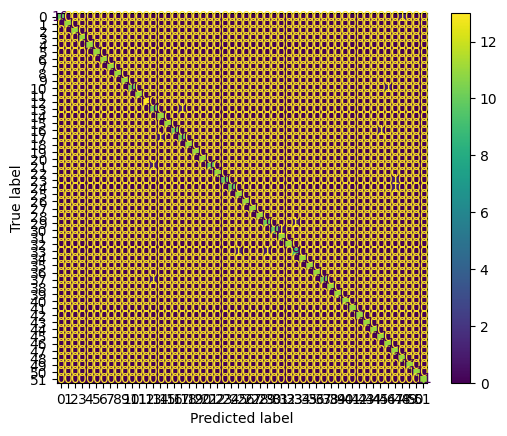

In [31]:
cm = confusion_matrix(Y_test_enc, Y_test_hat_enc)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot()

# 9. Prediction
---
Let's test our model on unseen data (test_df)

18/18 [==============================] - 1s 47ms/step


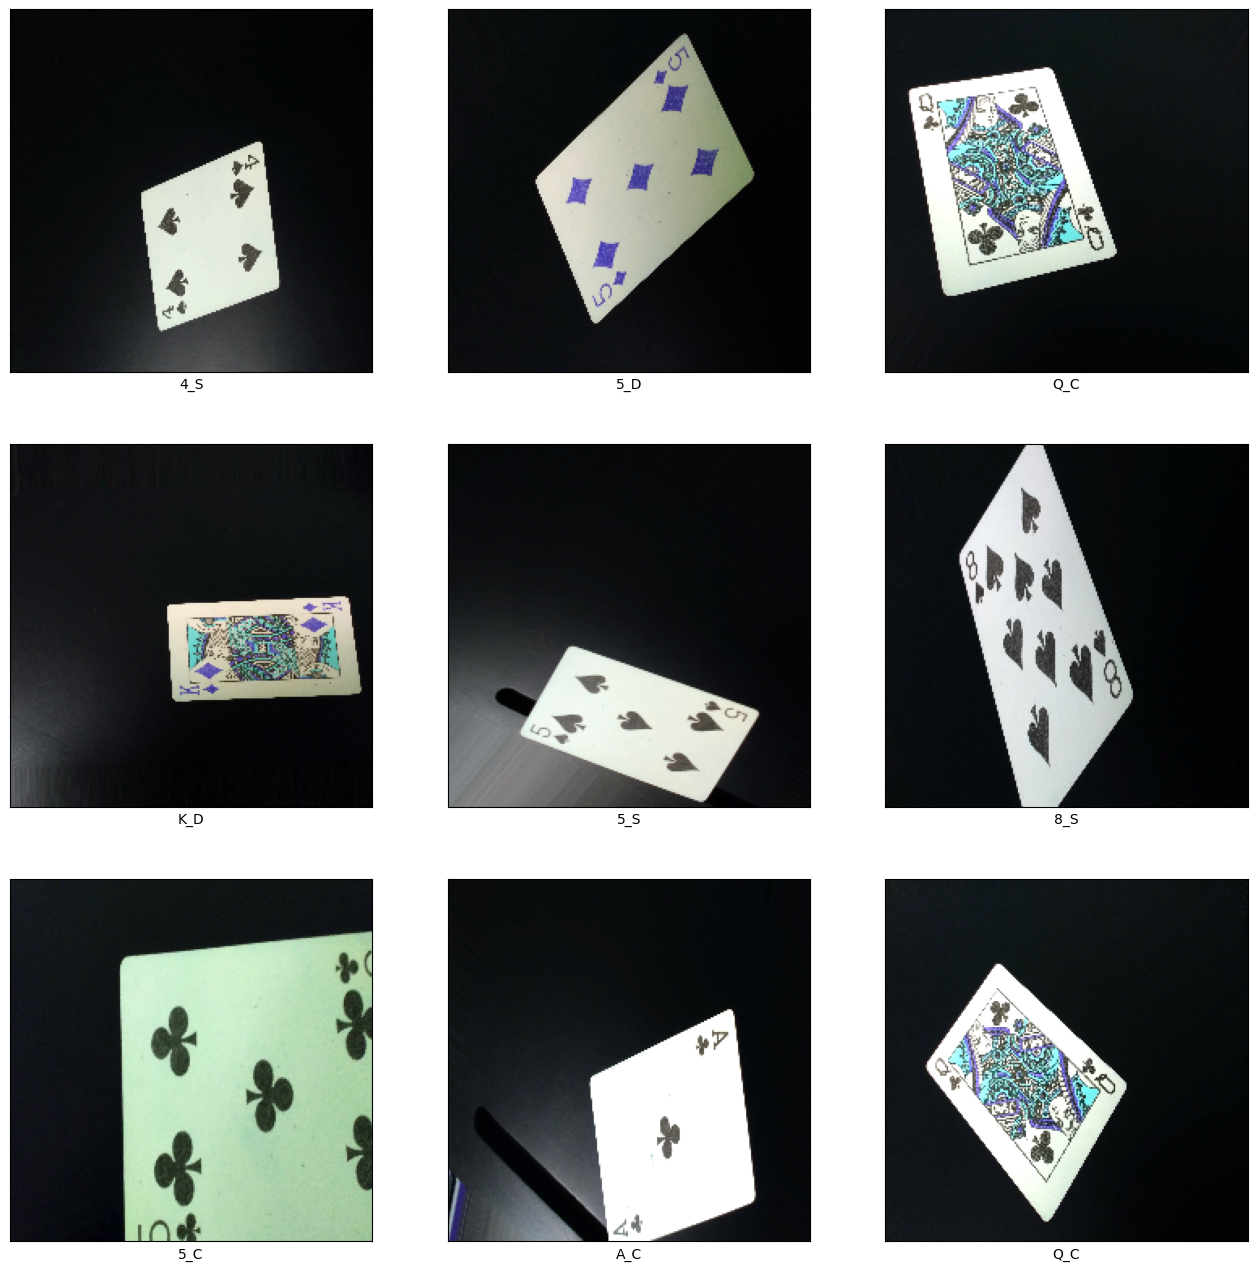

In [32]:
# # Load encoder
# label_encoder = LabelEncoder()
# if Path(label_encoder_fp).exists():
#   label_encoder.classes_ = np.load(label_encoder_fp)

# # Load model
# if Path(model_save_fp).exists():
#   model = load_model(model_save_fp)

predictions          =  model.predict(X_test, verbose=1)
Y_test_hat_enc       =  np.argmax(predictions, axis=1)
Y_test_hat           =  label_encoder.inverse_transform(Y_test_hat_enc)

# Lets visualize some predictions...
plt.figure(figsize=(16,16))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index])
    plt.xlabel(Y_test_hat[index])
plt.show()

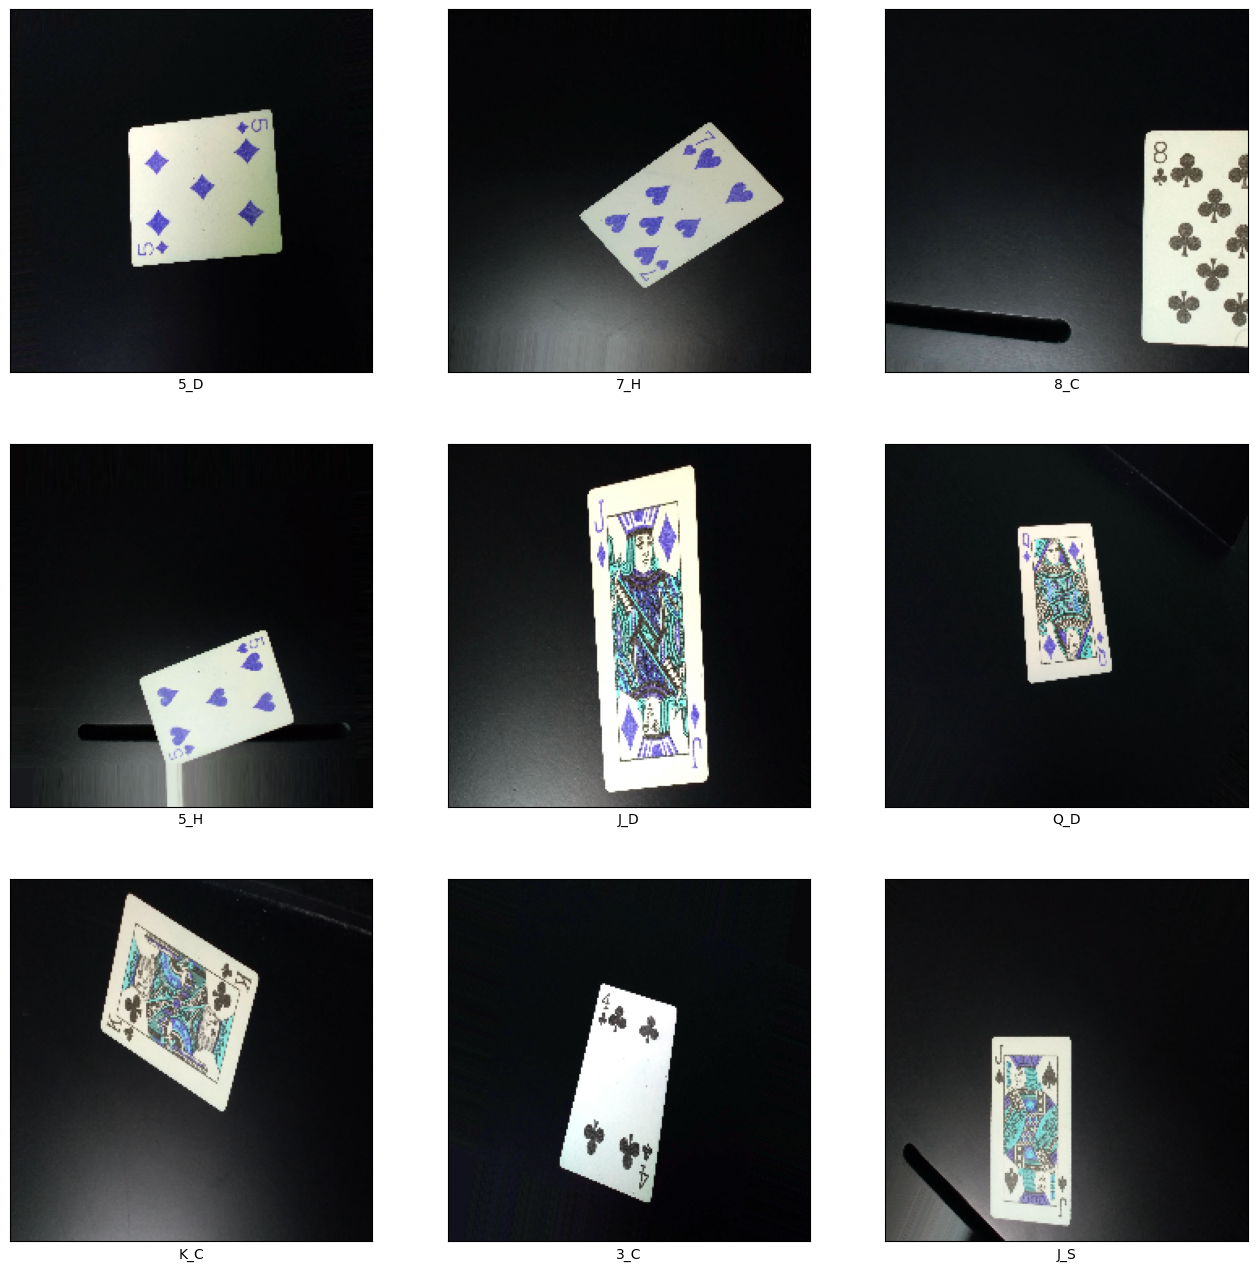

- This marks the end of Stage 1.

----
----